In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#export
from nb_003b import *

In [3]:
from nb_004 import loss_batch, accuracy

### Sanity check for rectangular validation

In [4]:
DATA_PATH = Path.home()/'data'
PATH = DATA_PATH/'imagenet'
VALPATH = PATH/'validation'

In [5]:
target_size = 224
batch_size = 256

In [33]:
def top5(output, target, topk=(5,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res[0]

### Load pretrained torchvision model

In [7]:
from torchvision.models import resnet50

In [14]:
model = resnet50(pretrained=True).cuda().eval()
model.avgpool = nn.AdaptiveAvgPool2d(1)

### Load original dawn validation

In [15]:
valid_ds = FilesDataset.from_folder(VALPATH)

In [16]:
len(valid_ds.classes)

1000

In [17]:
# val_tfms = [resize_image(size=target_size*1.14, do_crop=True)]
val_tfms = [resize_image(size=target_size*1.14, do_crop=True), crop(size=target_size)]

# val_tfms = [crop(size=target_size)]
# val_tfms=None

In [18]:
valid_ds_tfm = DatasetTfm(valid_ds, tfms=val_tfms)

In [19]:
index = 342

In [20]:
valid_ds_tfm[index][0].shape

torch.Size([3, 224, 224])

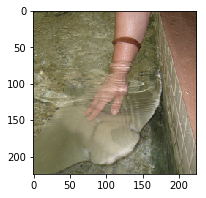

In [21]:
show_image(valid_ds_tfm[index][0].cpu(), hide_axis=False)

In [22]:
data_mean, data_std = map(tensor, ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))
data_norm,data_denorm = normalize_funcs(data_mean,data_std)

In [23]:
num_workers=8
# valid_dl = DataLoader(valid_ds, num_workers=num_workers, batch_sampler=valid_samp)
valid_dl = DataLoader(valid_ds_tfm, batch_size, num_workers=num_workers)
valid_dl = DeviceDataLoader(valid_dl, device=torch.cuda.current_device(), tfms=data_norm)

In [24]:
x,y = next(iter(valid_dl))

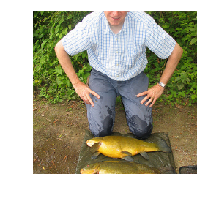

In [25]:
show_image(data_denorm(x[0].cpu()))

In [26]:
x.type(), x.shape

('torch.cuda.FloatTensor', torch.Size([256, 3, 224, 224]))

### Validate model

In [27]:
val_iter = iter(valid_dl)

In [28]:
x,y = next(val_iter)

In [30]:
with torch.no_grad():
    out = model(x)
accuracy(out, y), top5(out,y)

(tensor(0.8359, device='cuda:0'), [tensor([96.8750], device='cuda:0')])

### Sanity check: Validate using pytorch dataloader

In [37]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [38]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
tensor_tfm = [transforms.ToTensor(), normalize]

val_tfms = [transforms.Resize(int(target_size*1.14)), transforms.CenterCrop(target_size)] + tensor_tfm
val_dataset = datasets.ImageFolder(VALPATH,  transforms.Compose(val_tfms))

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=8, pin_memory=True)
#     num_workers=8, pin_memory=True, sampler=val_sampler_ar)

In [ ]:
val_iter = iter(val_loader)

In [ ]:
xb,yb = next(val_iter)
xb, yb = xb.cuda(), yb.cuda()

In [ ]:
with torch.no_grad():
    eval = loss_batch(model, xb, yb, loss_fn=loss_fn, metrics=[accuracy])
eval

In [ ]:
with torch.no_grad():
    out = model(xb)
accuracy(out, yb)

In [40]:
with torch.no_grad():
    *val_metrics,nums = zip(*[loss_batch(model, xb.cuda(), yb.cuda(), loss_fn, metrics=[top5])
                    for xb,yb in tqdm(val_loader)])
agg = [np.sum(np.multiply(val,nums)) / np.sum(nums) for val in val_metrics]; agg

[0.9624110203552246, 92.892]

In [ ]:
validate(val_loader, model, F.cross_entropy)

### Now validate with our own

In [34]:
loss_fn = F.cross_entropy

In [35]:
model.eval()
with torch.no_grad():
    *val_metrics,nums = zip(*[loss_batch(model, xb, yb, loss_fn, metrics=[top5])
                    for xb,yb in tqdm(valid_dl)])
val_metrics = [np.sum(np.multiply(val,nums)) / np.sum(nums) for val in val_metrics]; val_metrics

[0.9949007690811157, 92.598]

In [ ]:
val_metrics

In [ ]:
xb,yb = next(iter(valid_dl))

In [ ]:
with torch.no_grad():
    eval = loss_batch(model, x, y, loss_fn=loss_fn, metrics=[accuracy])
eval

In [ ]:
with torch.no_grad():
    out = model(x)
accuracy(out, y)

### Square Rectangle validation

In [ ]:
valid_samp = SortAspectBatchSampler(valid_ds, bs=256)

In [ ]:
target_size = 288
batch_size = 256

# val_tfms = [resize_image(size=target_size*1.14)]
val_tfms = [resize_image(size=target_size*1.14, do_crop=True), crop(size=target_size)]

# val_tfms = [crop(size=target_size)]
# val_tfms=None

In [ ]:
from datetime import datetime
import time
fp16=False
def validate(val_loader, model, criterion, aug_loader=None, num_augmentations=0):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    start_time = datetime.now()

    model.eval()
    end = time.time()

    val_iter = iter(val_loader)
    aug_iters = [iter(aug_loader) for i in range(num_augmentations)]
    prec5_arr = []
    for i in range(len(val_loader)):
        def get_output(dl_iter):
            input,target = next(dl_iter)
            input, target = input.cuda(), target.cuda()
            if fp16: input = input.half()

            # compute output
            with torch.no_grad():
                output = model(input)
                loss = criterion(output, target)
            return output, loss, input, target
        
        # Normal Validation
        output,loss,input,target = get_output(val_iter)
        
        # TTA
        for aug_iter in aug_iters:
            o,l,_,_ = get_output(aug_iter)
            output.add_(o)
            loss.add_(l)
        loss.div_(num_augmentations+1)
        
        # measure accuracy and record loss
        prec1, prec5 = accuracy(output.data, target, topk=(1, 5))
        reduced_loss = loss.data
            
        losses.update(to_python_float(reduced_loss), input.size(0))
        top1.update(to_python_float(prec1), input.size(0))
        top5.update(to_python_float(prec5), input.size(0))
        prec5_arr.append(to_python_float(prec5))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if ((i+1)%100 == 0) or ((i+1) == len(val_loader)):
            output = ('Test: [{0}/{1}]\t' \
                    + 'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t' \
                    + 'Loss {loss.val:.4f} ({loss.avg:.4f})\t' \
                    + 'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t' \
                    + 'Prec@5 {top5.val:.3f} ({top5.avg:.3f})').format(
                    i+1, len(val_loader), batch_time=batch_time, loss=losses,
                    top1=top1, top5=top5)
            print(output)

    time_diff = datetime.now()-start_time
    print(f'Total Time:{float(time_diff.total_seconds() / 3600.0)}\t Top 5 Accuracy: {top5.avg:.3f}\n')
    print(' * Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))

    return prec5_arr

# item() is a recent addition, so this helps with backward compatibility.
def to_python_float(t):
    if hasattr(t, 'item'): return t.item()
    else: return t[0]
    
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self): self.reset()
    def reset(self): self.val = self.avg = self.sum = self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res